# Interactive analysis of a Fortran Model (MOM6) in SmartSim

This simple example showcases how one could use SmartSim to connect models written in Fortran(or C, C++) to a Jupyter notebook to harness the full power of Python's data analytics stack. It is split up into 3 sections:
 1. Describing the setup of a SmartSim experiment using a Fortran-based simulation model
 2. Plotting output from the model as the model is running
 3. Estimate the trend of layer thickness after 30 days of model integration

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Import SmartSim
from smartsim import Experiment, Client

## 1.1 Setting up the double-gyre experiment in the Fortran-based Modular Ocean Model
 - A SmartSim `experiment` is a stateful object holds all the entities(models, orchestrator, nodes) defined by the user
 - To run a simulation model like MOM6, a SmartSim `model` is created, run settings defined, and added to the experiment
 - The MOM6 source code has been modified to send daily averaged layer thicknesses via the Fortran client
 - These fields sent from the model will be stored in a multi-threaded distributed database (KeyDB)
 - The double-gyre domain is decomposed into 16 subdomains which are updated via MPI
 - All the model configuration files are 'attached' to the model and will be copied into the run directory

In [2]:
database_cluster_size = 3
MOM6_node_size = 1
MOM6_ppn = 32
experiment = Experiment("MOM6-interaction")
alloc = experiment.get_allocation(nodes=database_cluster_size + MOM6_node_size, ppn=16)
MOM6_settings= {
    "ppn": MOM6_ppn,
    "nodes": MOM6_node_size,
    "duration": "1:00:00",
    "executable": "/home/users/ashao/snx11254/scratch/MOM6-examples/build/gnu/ocean_only/repro/MOM6",
    "partition": "iv24",
    "alloc":alloc
}
mom6 = experiment.create_model("MOM6", run_settings=MOM6_settings)
orc = experiment.create_orchestrator_cluster(alloc, db_nodes=database_cluster_size, dpn=1, partition="iv24")
mom6.attach_generator_files(to_copy='./MOM6_base_config')
experiment.generate()


2020-07-15 23:28:18 cicero smartsim.control.controller[26130] INFO Attempting to obtain allocation...
2020-07-15 23:28:21 cicero smartsim.launcher.slurm.slurmLauncher[26130] INFO Allocation successful with Job ID: 122672
2020-07-15 23:28:21 cicero smartsim.generation.generator[26130] INFO Generated 1 models for ensemble: default


## 1.2 Starting the experiment
  - `experiment.start()` is a non-blocking command so that interactive execution may follow
  - Here we see output confirming that we have obtained our allocation, and the in-memory database has been constructed.

In [3]:
experiment.start(orchestrator=orc)

2020-07-15 23:28:28 cicero smartsim.experiment[26130] INFO Starting experiment: MOM6-interaction
2020-07-15 23:28:40 cicero smartsim.launcher.clusterLauncher[26130] INFO KeyDB Cluster has been created with 3 nodes
2020-07-15 23:28:47 cicero smartsim.control.controller[26130] INFO All entities launched


## Section 2 Plotting output from the model interactively
The model will be sending data to the database as it integrates. Here, we use initialize an instance of the Python client within the notebook, pull data from the database, reconstruct the global domain from the 32 subdomains and make plots interactively as the model is running.

## 2.1 Initializing the client
  - In order to connect the Jupyter notebook to the simulation, the SmartSim python client needs to be initialized
  - All that is needed is to export the address of the database used by the experiment above
  - We signify `cluster=True` in the initialization of the client to inform the client that we should be interfacing with a clustered database.

In [7]:
os.environ["SSDB"] = experiment.get_db_address()[0]
client = Client(cluster=True)

## 2.2 Interactively plot output from the model as available
- MOM6 will be sending daily averaged layer thicknesses from each of the 32 subdomains every 5-10 seconds.
- On initialization, MOM6 sent metadata designating the starting location of each subdomain in the global array
- The following functions are used to reconstruct the global array from the subdomains at a given timestamp
- The first two retrieve double-precision or integer arrays matching the given key. These are blocking calls and will not complete until the keys are available in the database
- The last one returns the global array

In [41]:
def retrieve_all_ranks_float64(client, key_suffix, nranks, dtype="float64"):
    ''' Retrieve a double-precision array from the database by its key
    '''
    retrieve_d = {}
    # Loop over all processors to retrieve each subdomain
    for rank in range(nranks):
        # MOM6 was setup so that keys sent from each processor would prepend its zero-padded MPI rank
        rank_id= f'{rank:05d}'
        key = f'{rank_id}_{key_suffix}'
        retrieve_d[rank_id] = client.get_array_nd_float64(f'{rank_id}_{key_suffix}', wait=True)
    return retrieve_d
def retrieve_all_ranks_int32(client, key_suffix, nranks, dtype="int32"):
    ''' Retrieve a double-precision array from the database by its key
    '''
    retrieve_d = {}
    for rank in range(nranks):
        rank_id= f'{rank:05d}'
        key = f'{rank_id}_{key_suffix}'
        retrieve_d[rank_id] = client.get_array_nd_int32(f'{rank_id}_{key_suffix}', wait=True)
    return retrieve_d

def reconstruct_domain(client, timestamp, nranks, print_time_elapsed = False):
    """Reconstruct the domain of MOM6 by rank at the specified timestep of the model
    """
    start_iter = time.time()

    # Retrieve the array metadata needed to reconstruct a global array from each subdomain
    meta_rank = retrieve_all_ranks_int32(client, "rank-meta" ,nranks)
    
    # Calculate the starting index in the global array
    starti_rank  = np.array([int(meta[0]) for meta in meta_rank.values()])
    startj_rank  = np.array([int(meta[1]) for meta in meta_rank.values()])
    glob_starti_rank = starti_rank - min(starti_rank)
    glob_startj_rank = startj_rank - min(startj_rank)

    t1 = time.time()
    
    # Retrieve layer thicknesses from each subdomain
    h_rank = retrieve_all_ranks_float64(client, f'{timestamp}_h',nranks)

    # Number of ranks that the domain was decomposed along
    ni_rank = np.array( [ h.shape[-1] for h in h_rank.values()] )
    nj_rank = np.array( [ h.shape[-2] for h in h_rank.values()] )
    nk_rank = np.array( [ h.shape[-3] for h in h_rank.values()] )

    # Ending index of the global array
    glob_endi_rank = glob_starti_rank + ni_rank - 1
    glob_endj_rank = glob_startj_rank + nj_rank - 1
    ni_glob = max(glob_endi_rank) + 1 
    nj_glob = max(glob_endj_rank) + 1
    nk_glob = max(nk_rank)

    # Initialize the global array
    h_glob = np.zeros([nk_glob,nj_glob,ni_glob])

    # Loop over all the rtrieved subdomains and reconstruct the global array
    for rank in range(nranks):
        si = glob_starti_rank[rank]
        sj = glob_startj_rank[rank]
        ei = glob_endi_rank[rank] + 1
        ej = glob_endj_rank[rank] + 1

        h_glob[:,sj:ej,si:ei] = h_rank[f'{rank:05d}']
    
    iter_time = time.time() - start_iter
    if print_time_elapsed:
        print(f"Time elapsed in iteration: {iter_time}")
        
    return h_glob


## 2.3 Online Interaction with the Simulation
 - The following loop plots the difference in layer thickness since the first day of the simulation for the first 12 days of the simulation as soon as they are available

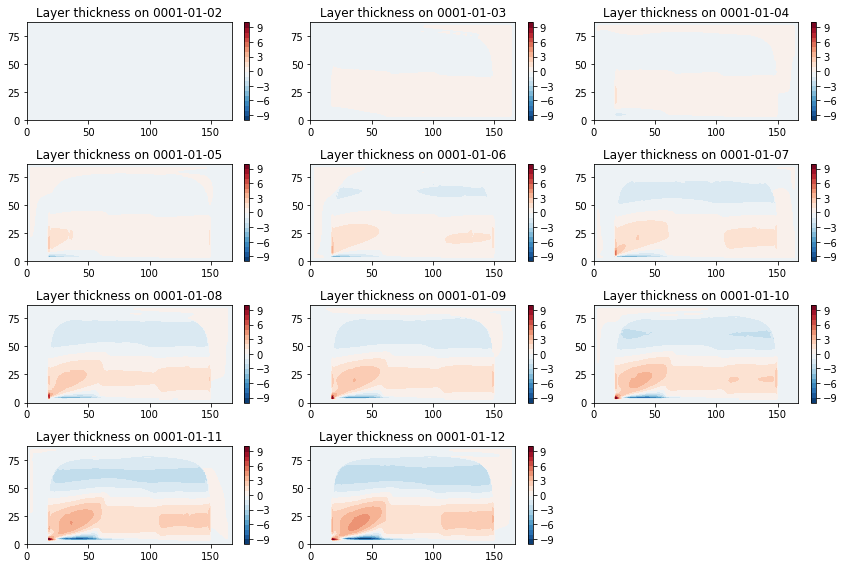

In [42]:
day2_layer_thickness = reconstruct_domain(client, f"0001-01-02", 32)
plt.figure(figsize=(12,8))
for day in range(2,13):
    layer_thickness = reconstruct_domain(client, f"0001-01-{day:02d}", 32)
    plt.subplot(4,3,day-1)
    plt.contourf(layer_thickness[0,...]-day2_layer_thickness[0,...],levels=np.linspace(-10,10,21),cmap='RdBu_r')
    plt.colorbar()    
    plt.title(f'Layer thickness on 0001-01-{day:02d}')
plt.tight_layout()

## Section 3 Timeseries analysis
The trend in layer thickness in month 2 is computed whenever the fields are ready

 1. Loop over days 1-30 in month 2, collecting thicknesses in a 4D array
 2. Use numpy's polyfit to find the best linear fit to the data
 3. Plot the trends as a spatial map

In [43]:
ndays = 30
month2_thicknesses = np.zeros((ndays,) + layer_thickness.shape)
for dayidx in range(ndays):
    month2_thicknesses[dayidx,...] = reconstruct_domain(client, f"0001-02-{dayidx+1:02d}", 32)

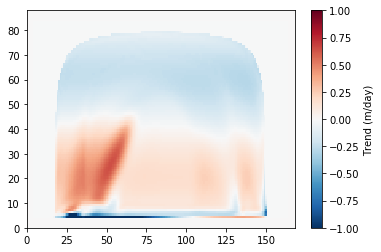

In [47]:
ndays, nk, nlat, nlon = month2_thicknesses.shape
flattened = month2_thicknesses[:,0,...].reshape((ndays,nlat*nlon))
trends = np.zeros(nlat*nlon)
for pt in range(nlat*nlon):
    trends[pt] = np.polyfit(range(ndays),flattened[:,pt],1)[0]
plt.pcolormesh(trends.reshape(nlat,nlon),vmin=-1.,vmax=1.,cmap='RdBu_r')
plt.colorbar(label='Trend (m/day)')

## Finally release the allocations that SmartSim has obtained
  - Now that we are done analyzing our model, we will release the allocations we obtained through a call to the experiment API.

In [48]:
experiment.release()

2020-07-15 23:47:00 cicero smartsim.launcher.slurm.slurmLauncher[26130] INFO Releasing allocation: 122672
2020-07-15 23:47:00 cicero smartsim.launcher.slurm.slurmLauncher[26130] INFO Successfully freed allocation 122672
